In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import time
import pathlib
import os
import scipy.io
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import h5py
from torchvision import transforms
from torch.utils.data import Subset
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MRI Data set


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, mat_files, transform=None):
        self.mat_files = mat_files
        self.transform = transform

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        with h5py.File(self.mat_files[idx], "r") as f:
            image = f["cjdata"]["image"][()]

            label = int(f["cjdata"]["label"][0][0] - 1)

            image = Image.fromarray(image)
            if self.transform:
                image = self.transform(image)

        return image, label


mat_files = [
    os.path.join("./data/New folder/", f)
    for f in os.listdir("./data/New folder/")
    if f.endswith(".mat")
]

indices = list(range(len(mat_files)))
split = int(np.floor(0.7 * len(mat_files)))
np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]

In [4]:
class MinMaxNormalize:
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, image):
        image_np = np.array(image)

        normalized_image_np = (image_np - self.min_val) / (self.max_val - self.min_val)

        normalized_image = Image.fromarray((normalized_image_np * 255).astype(np.uint8))

        return normalized_image


Z_min = 0
Z_max = 255

transforming_img = transforms.Compose(
    [
        transforms.Lambda(MinMaxNormalize(Z_min, Z_max)),  # Normalize first
        transforms.Resize((227, 227)),  # Then resize
        transforms.ToTensor(),  # Convert the resized image to tensor
    ]
)

train_set_MRI = Subset(
    BrainTumorDataset(mat_files, transform=transforming_img), train_indices
)
test_set_MRI = Subset(
    BrainTumorDataset(mat_files, transform=transforming_img), test_indices
)

train_loader_MRI = torch.utils.data.DataLoader(
    train_set_MRI, batch_size=10, shuffle=True
)
test_loader_MRI = torch.utils.data.DataLoader(test_set_MRI, batch_size=10)

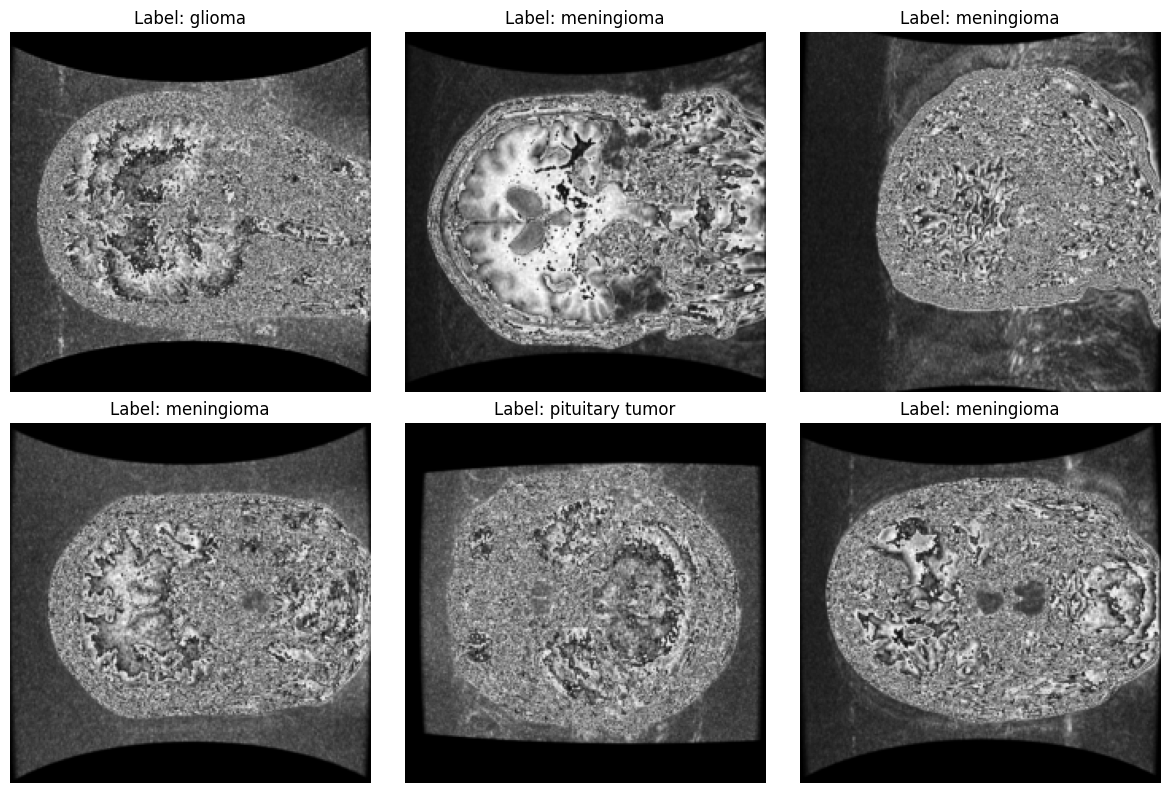

In [5]:
def plot_samples(dataset, num_samples=6):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    tumor_types = {0: "meningioma", 1: "glioma", 2: "pituitary tumor"}

    for i in range(2):
        for j in range(3):
            idx = np.random.randint(0, len(dataset))
            image, label = dataset[idx]

            # Convert PyTorch tensor to numpy array and display the image
            axs[i, j].imshow(image.squeeze().numpy(), cmap="gray")
            axs[i, j].set_title(f"Label: {tumor_types[label]}")
            axs[i, j].axis("off")

    for label, tumor in tumor_types.items():
        axs[0, 0].plot([], label=f"{label}: {tumor}", color="white")

    plt.tight_layout()
    plt.savefig("MRIData.pdf")
    plt.show()


plot_samples(train_set_MRI)

# CNN Architecture


In [6]:
class MyCNN(nn.Module):
    def __init__(
        self,
        input_size=28,
        kernel_size=5,
        num_filters1=32,
        num_filters2=64,
        dropout_rate=0.5,
        in_channels=1,
        classes=10,
    ):
        super(MyCNN, self).__init__()

        self.kernel_size = kernel_size
        self.input_size = input_size
        self.pool_kernel_size = 3
        self.pool_stride = 3

        # Compute output sizes after conv and pool operations
        conv1_out_size = self.input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size - self.pool_kernel_size
        ) // self.pool_stride + 1

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = (
            conv2_out_size - self.pool_kernel_size
        ) // self.pool_stride + 1

        fc_input_size = num_filters2 * pool2_out_size * pool2_out_size
        print(fc_input_size)
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_filters1,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters1),
            nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_filters1,
                out_channels=num_filters2,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters2),
            nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride),
        )
        self.drop = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(fc_input_size, classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

33856
Input: torch.Size([10, 1, 227, 227])
After layer1: torch.Size([10, 32, 74, 74])
After layer2: torch.Size([10, 64, 23, 23])
After reshaping: torch.Size([10, 33856])
After dropout: torch.Size([10, 33856])
After fc1: torch.Size([10, 3])
After softmax: torch.Size([10, 3])


64
Input: torch.Size([10, 1, 28, 28])
After layer1: torch.Size([10, 32, 8, 8])
After layer2: torch.Size([10, 64, 1, 1])
After reshaping: torch.Size([10, 64])
After dropout: torch.Size([10, 64])
After fc1: torch.Size([10, 10])
After softmax: torch.Size([10, 10])


# Train - Test Functions


In [7]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss, all_predicted, all_labels

# Plot Function


In [8]:
def PlotResults(
    train_accuracies, test_accuracies, train_losses, test_losses, epochs, name
):
    epoch_range = list(range(1, epochs + 1))
    # Visualizing the accuracy results
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_range, train_accuracies, "ko--", label="Training Accuracy")
    plt.plot(epoch_range, test_accuracies, "ro--", label="Testing Accuracy")
    plt.title("Training and Testing Accuracy over Epochs", size=18)
    plt.xlabel("Epochs", size=15)
    plt.ylabel("Accuracy (%)", size=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(epoch_range)
    plt.tight_layout()
    plt.savefig(f"Training_and_Testing_Accuracy_{name}.pdf")
    plt.show()

    # Visualizing the loss results
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_range, train_losses, "ko--", label="Training Loss")
    plt.plot(epoch_range, test_losses, "ro--", label="Testing Loss")
    plt.title("Training and Test Loss over Epochs", size=18)
    plt.xlabel("Epochs", size=15)
    plt.ylabel("Loss", size=15)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(epoch_range)
    plt.tight_layout()
    plt.savefig(f"Training_and_Testing_Loss_{name}.pdf")
    plt.show()

# Plot Confusion_Matrix


In [9]:
def plot_confusion_matrix(true, pred, classes, name="Confusion Matrix"):
    matrix = confusion_matrix(true, pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted Label", size=15)
    plt.ylabel("True Label", size=15)
    plt.title(name, size=20)
    plt.savefig(f"Matix_{name}.pdf")
    plt.show()

    precision = precision_score(true, pred, average="macro")
    recall = recall_score(true, pred, average="macro")
    accuracy = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate Function


In [10]:
def train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=30,
    name="Model",
    MRIData=True,
):
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(num_epochs):
        train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
        test_accuracy, test_loss, _, _ = test(model, test_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

    print("Training and testing completed!")

    PlotResults(
        train_accuracies,
        test_accuracies,
        train_losses,
        test_losses,
        num_epochs,
        name,
    )
    if MRIData:
        classes = ["meningioma", "glioma", "pituitary tumor"]
    else:
        classes = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]

    _, _, all_predicted, all_labels = test(model, test_loader)
    plot_confusion_matrix(all_labels, all_predicted, classes=classes, name=name)

# MRI Initial using same hyper parameters as the paper


In [31]:
model = MyCNN(input_size=227, classes=3, in_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
summary(model, (1, 227, 227))

33856
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 223, 223]             832
              ReLU-2         [-1, 32, 223, 223]               0
       BatchNorm2d-3         [-1, 32, 223, 223]              64
         MaxPool2d-4           [-1, 32, 74, 74]               0
            Conv2d-5           [-1, 64, 70, 70]          51,264
              ReLU-6           [-1, 64, 70, 70]               0
       BatchNorm2d-7           [-1, 64, 70, 70]             128
         MaxPool2d-8           [-1, 64, 23, 23]               0
           Dropout-9                [-1, 33856]               0
           Linear-10                    [-1, 3]         101,571
          Softmax-11                    [-1, 3]               0
Total params: 153,859
Trainable params: 153,859
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Fo

33856
Epoch [1/30], Train Accuracy: 51.99%, Test Accuracy: 60.29%, Train Loss: 1.0233, Test Loss: 0.9437
Epoch [2/30], Train Accuracy: 58.58%, Test Accuracy: 62.17%, Train Loss: 0.9617, Test Loss: 0.9260
Epoch [3/30], Train Accuracy: 68.66%, Test Accuracy: 78.12%, Train Loss: 0.8609, Test Loss: 0.7668
Epoch [4/30], Train Accuracy: 79.54%, Test Accuracy: 79.86%, Train Loss: 0.7540, Test Loss: 0.7486
Epoch [5/30], Train Accuracy: 82.09%, Test Accuracy: 83.91%, Train Loss: 0.7282, Test Loss: 0.7114
Epoch [6/30], Train Accuracy: 84.27%, Test Accuracy: 84.06%, Train Loss: 0.7019, Test Loss: 0.7070
Epoch [7/30], Train Accuracy: 85.95%, Test Accuracy: 82.75%, Train Loss: 0.6881, Test Loss: 0.7205
Epoch [8/30], Train Accuracy: 86.88%, Test Accuracy: 85.22%, Train Loss: 0.6810, Test Loss: 0.6983
Epoch [9/30], Train Accuracy: 86.75%, Test Accuracy: 82.03%, Train Loss: 0.6828, Test Loss: 0.7296
Epoch [10/30], Train Accuracy: 86.01%, Test Accuracy: 84.64%, Train Loss: 0.6911, Test Loss: 0.7059
Epo

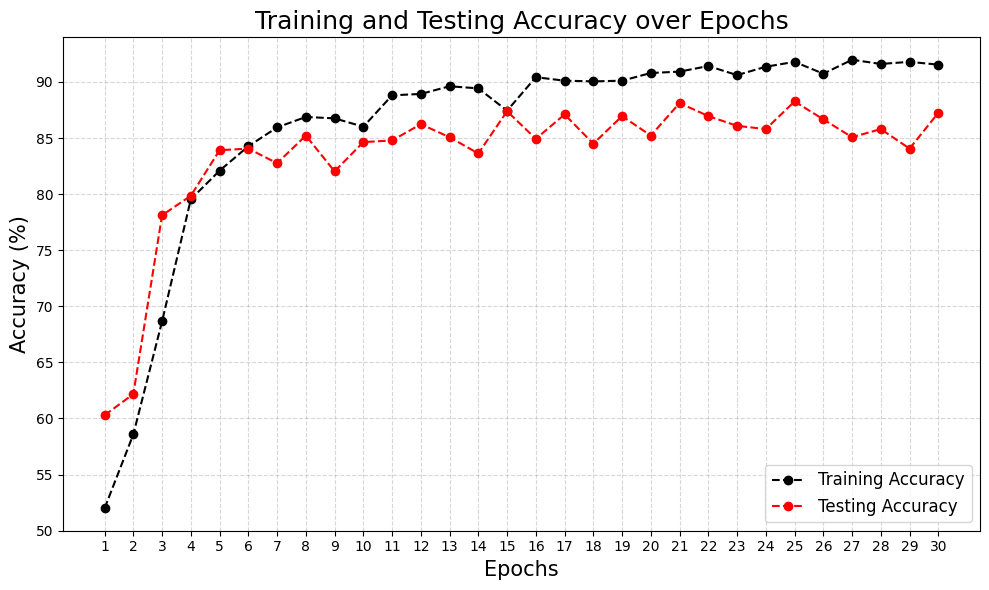

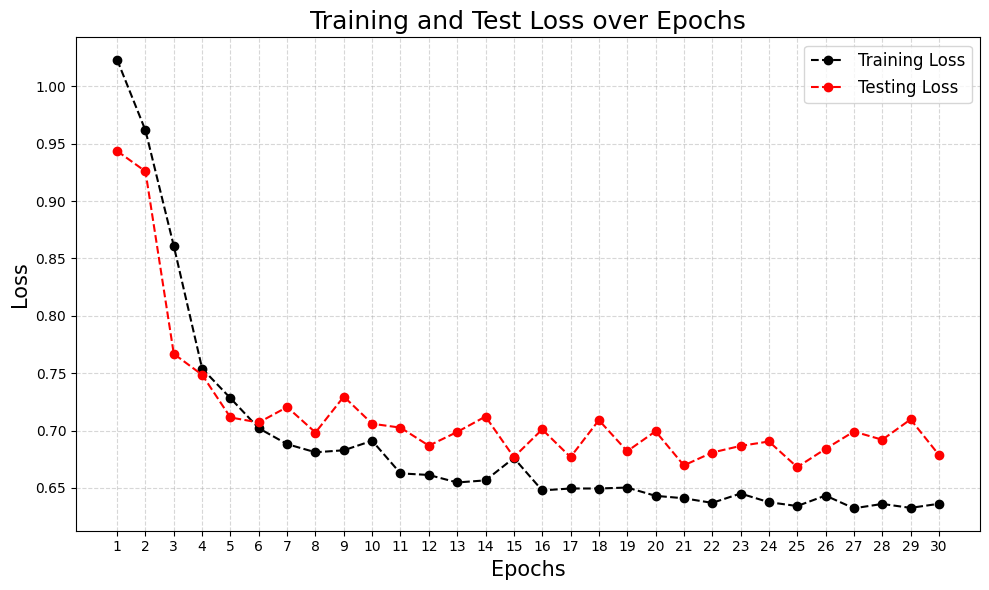

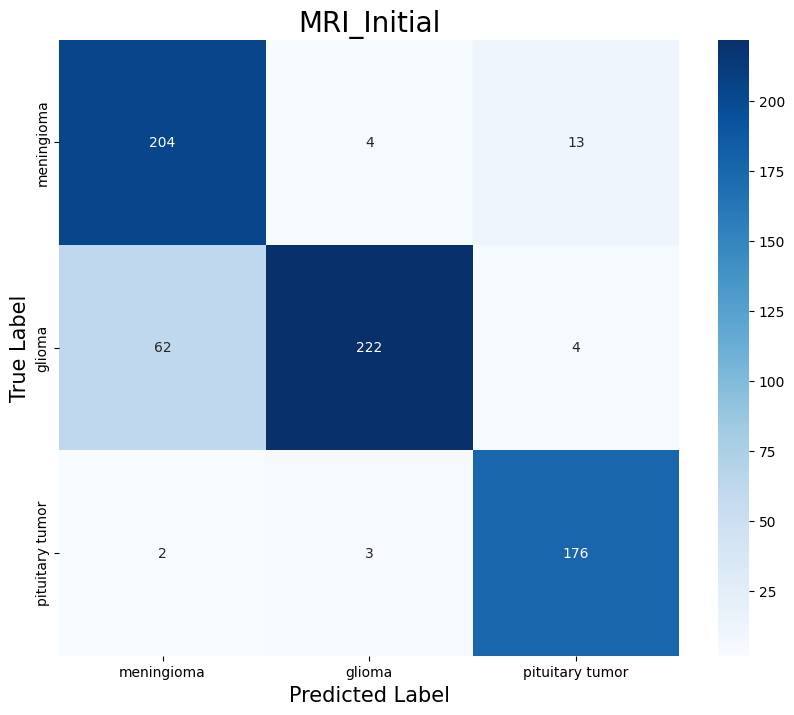

Precision: 0.8808
Recall: 0.8888
Accuracy: 0.8725
F1 Score: 0.8781


In [11]:

train_and_evaluate_model(
    model,
    train_loader_MRI,
    test_loader_MRI,
    criterion,
    optimizer,
    num_epochs=30,
    name="MRI_Initial",
)

# FMnist Data set


In [12]:
transforming_img = transforms.Compose(
    [
        transforms.Lambda(MinMaxNormalize(Z_min, Z_max)),
        transforms.ToTensor(),
    ]
)

train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforming_img
)


test_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transforming_img
)

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

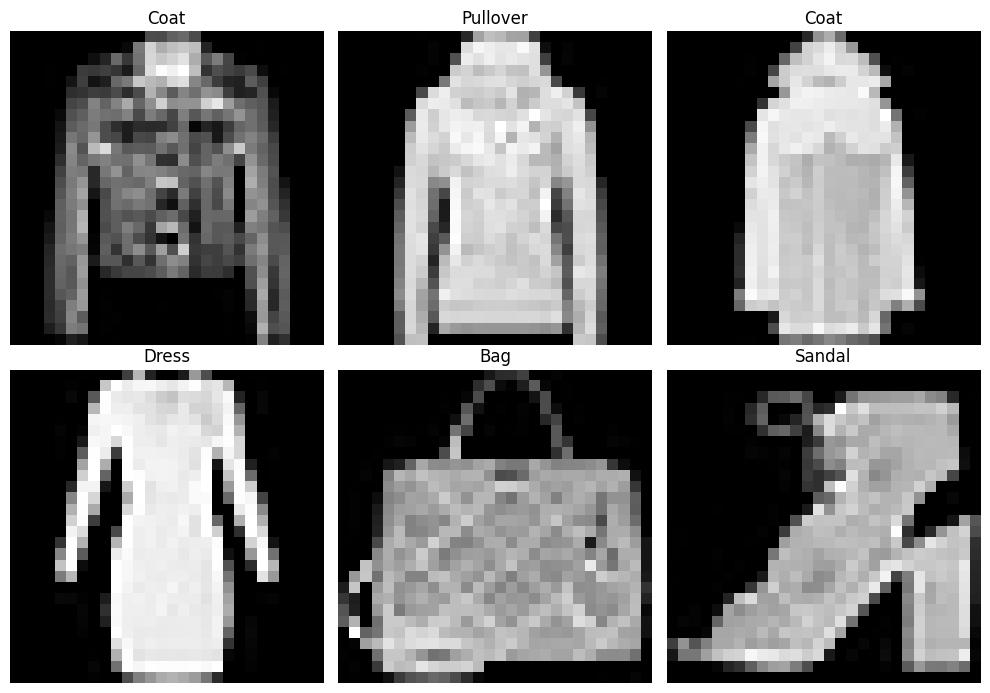

In [14]:
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)


dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(np.squeeze(images[idx].numpy()), cmap="gray")
        axs[i, j].set_title(classes[labels[idx]], fontsize=12)
        axs[i, j].axis("off")

plt.tight_layout()
plt.savefig("FmnistData.pdf")
plt.show()

In [15]:
print(len(train_set))
print(len(test_set))

60000
10000


# FMnist Initial using same parameter as paper


In [32]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
summary(model, (1, 28, 28))

64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
       BatchNorm2d-3           [-1, 32, 24, 24]              64
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          51,264
              ReLU-6             [-1, 64, 4, 4]               0
       BatchNorm2d-7             [-1, 64, 4, 4]             128
         MaxPool2d-8             [-1, 64, 1, 1]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
          Softmax-11                   [-1, 10]               0
Total params: 52,938
Trainable params: 52,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward

64
Epoch [1/30], Train Accuracy: 76.93%, Test Accuracy: 83.62%, Train Loss: 1.7091, Test Loss: 1.6280
Epoch [2/30], Train Accuracy: 82.54%, Test Accuracy: 85.39%, Train Loss: 1.6429, Test Loss: 1.6109
Epoch [3/30], Train Accuracy: 84.32%, Test Accuracy: 86.11%, Train Loss: 1.6228, Test Loss: 1.6034
Epoch [4/30], Train Accuracy: 85.20%, Test Accuracy: 86.51%, Train Loss: 1.6130, Test Loss: 1.5992
Epoch [5/30], Train Accuracy: 85.93%, Test Accuracy: 86.84%, Train Loss: 1.6048, Test Loss: 1.5940
Epoch [6/30], Train Accuracy: 86.32%, Test Accuracy: 86.78%, Train Loss: 1.6007, Test Loss: 1.5953
Epoch [7/30], Train Accuracy: 86.70%, Test Accuracy: 87.35%, Train Loss: 1.5962, Test Loss: 1.5881
Epoch [8/30], Train Accuracy: 86.93%, Test Accuracy: 87.24%, Train Loss: 1.5935, Test Loss: 1.5891
Epoch [9/30], Train Accuracy: 87.38%, Test Accuracy: 87.54%, Train Loss: 1.5889, Test Loss: 1.5859
Epoch [10/30], Train Accuracy: 87.53%, Test Accuracy: 87.99%, Train Loss: 1.5875, Test Loss: 1.5825
Epoch 

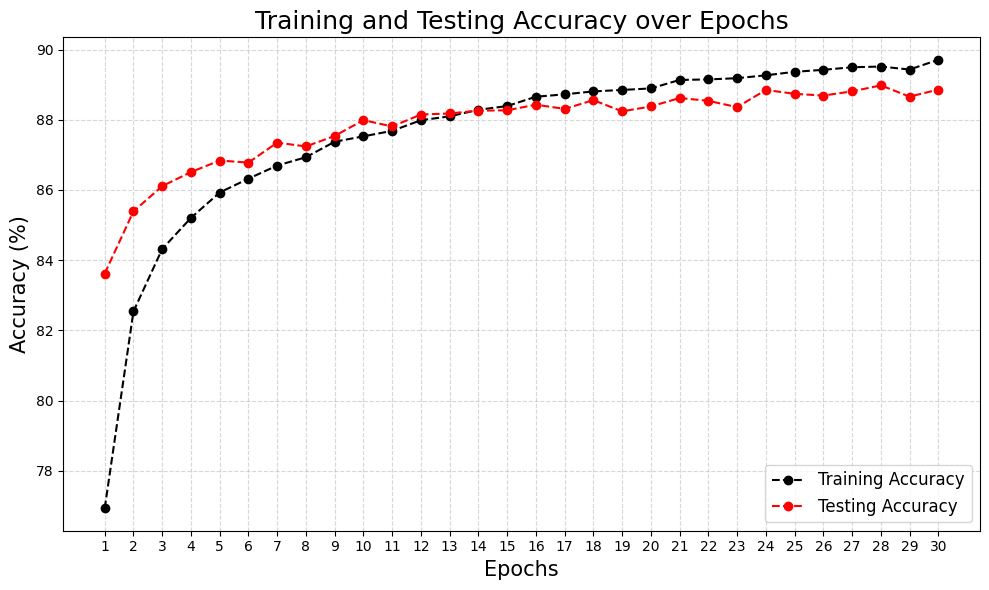

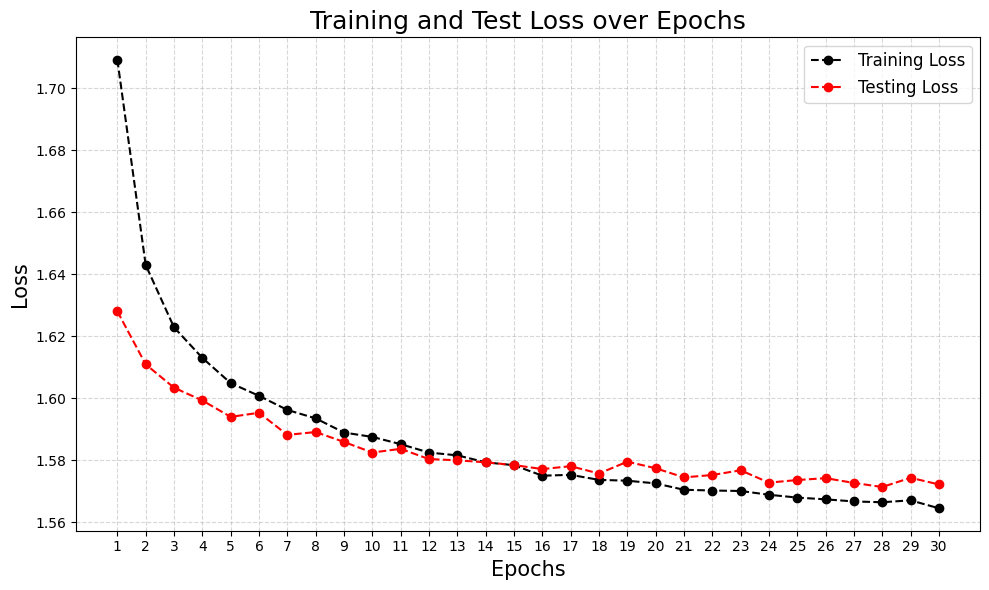

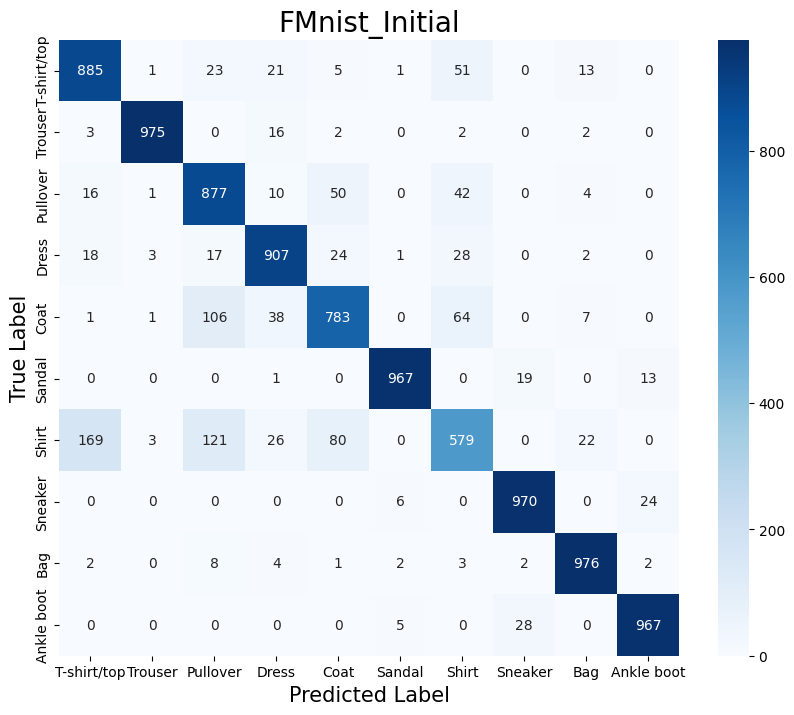

Precision: 0.8878
Recall: 0.8886
Accuracy: 0.8886
F1 Score: 0.8864


In [19]:

train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=30,
    name="FMnist_Initial",
    MRIData=False,
)

# Hyper Tuning


In [20]:
learning_rates = [0.0001, 0.00001, 0.000001]
batch_sizes = [10, 32, 64]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.3, 0.5, 0.6]
kernel_sizes = [3, 4, 5]
num_epochs = 10

best_accuracy = 0.0
best_params = {}

results = {}

config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader = torch.utils.data.DataLoader(
                        train_set, batch_size=bs, shuffle=True
                    )
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = MyCNN(kernel_size=ks, dropout_rate=dr).to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    total_train_loss = 0.0
                    total_test_loss = 0.0
                    start_time = time.time()

                    for epoch in range(num_epochs):
                        train_accuracy, train_loss = train(
                            model, train_loader, criterion, optimizer
                        )
                        total_train_loss += train_loss

                        test_accuracy, test_loss, _, _ = test(model, test_loader)
                        total_test_loss += test_loss

                        print(f"Epoch {epoch+1}/{num_epochs}:")
                        print(
                            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {train_loss:.4f}"
                        )
                        print(
                            f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}"
                        )
                        print("----------------------------------------")

                    avg_train_loss = total_train_loss / num_epochs
                    avg_test_loss = total_test_loss / num_epochs
                    end_time = time.time()
                    config_time = end_time - start_time

                    results[config_key] = {
                        "Train Accuracy": train_accuracy,
                        "Test Accuracy": test_accuracy,
                        "Average Train Loss": avg_train_loss,
                        "Average Test Loss": avg_test_loss,
                        "Time (in sec)": config_time,
                    }

                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }
                    print("------------------------------------------------------")
                    config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Configuration 1/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.3, Kernel: 3
256
Epoch 1/10:
Train Accuracy: 29.71% - Train Loss: 2.1773
Test Accuracy: 44.85% - Test Loss: 2.0541
----------------------------------------
Epoch 2/10:
Train Accuracy: 53.85% - Train Loss: 1.9884
Test Accuracy: 65.42% - Test Loss: 1.8921
----------------------------------------
Epoch 3/10:
Train Accuracy: 65.15% - Train Loss: 1.8774
Test Accuracy: 70.44% - Test Loss: 1.8188
----------------------------------------
Epoch 4/10:
Train Accuracy: 69.82% - Train Loss: 1.8205
Test Accuracy: 73.12% - Test Loss: 1.7804
----------------------------------------
Epoch 5/10:
Train Accuracy: 71.89% - Train Loss: 1.7892
Test Accuracy: 74.77% - Test Loss: 1.7553
----------------------------------------
Epoch 6/10:
Train Accuracy: 73.67% - Train Loss: 1.7669
Test Accuracy: 75.95% - Test Loss: 1.7360
----------------------------------------
Epoch 7/10:
Train Accuracy: 74.63% - Train Loss: 1.7523
Test Accuracy: 76.85% - T

In [21]:
df_results = pd.DataFrame.from_dict(results, orient="index")

df_results.to_csv("./data/results.csv")

print("Results saved to 'results.csv'")

Results saved to 'results.csv'


# Optimized Fashion Mnist

256
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 6, 6]          18,496
              ReLU-6             [-1, 64, 6, 6]               0
       BatchNorm2d-7             [-1, 64, 6, 6]             128
         MaxPool2d-8             [-1, 64, 2, 2]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
          Softmax-11                   [-1, 10]               0
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

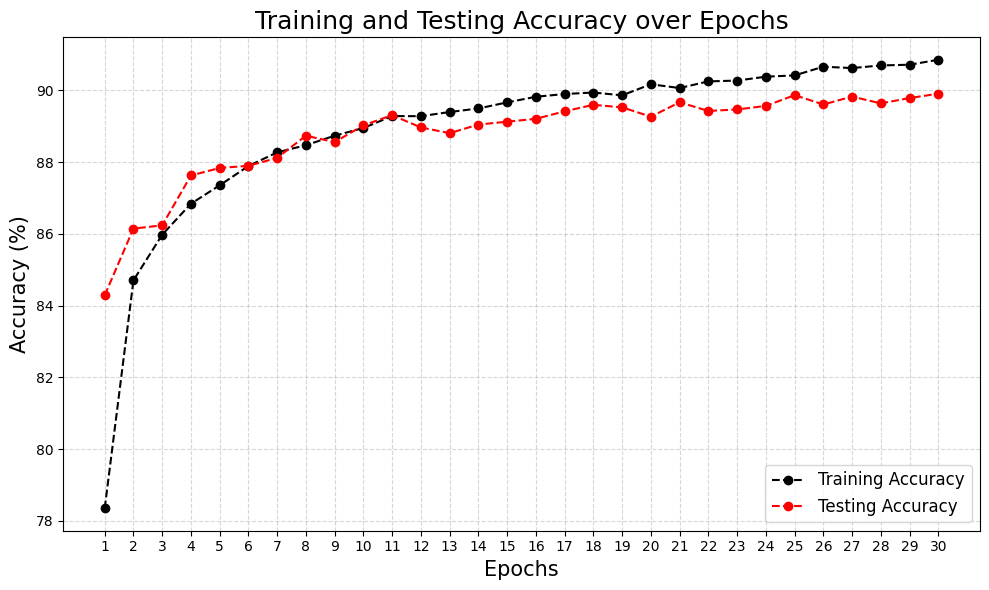

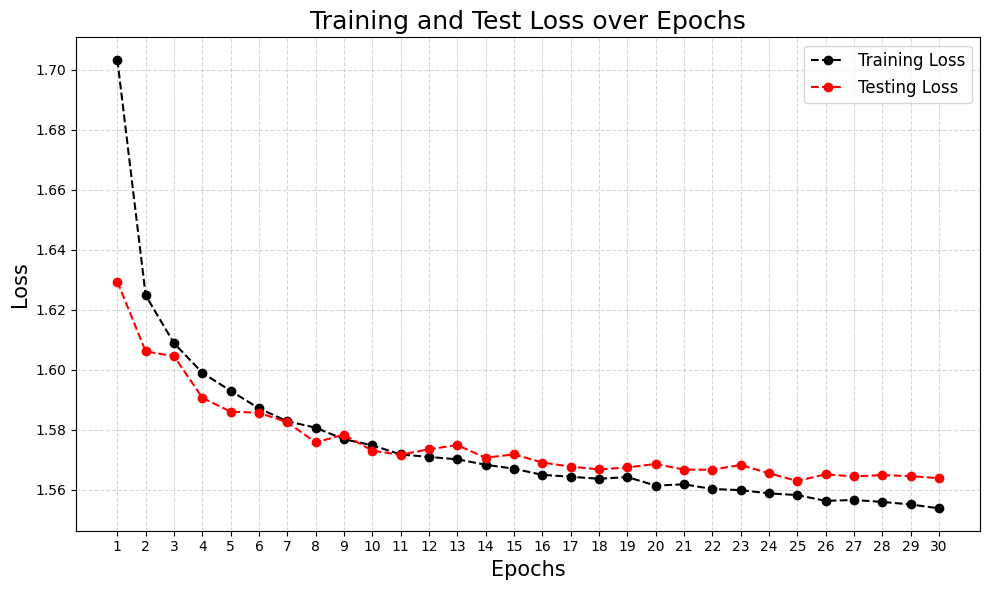

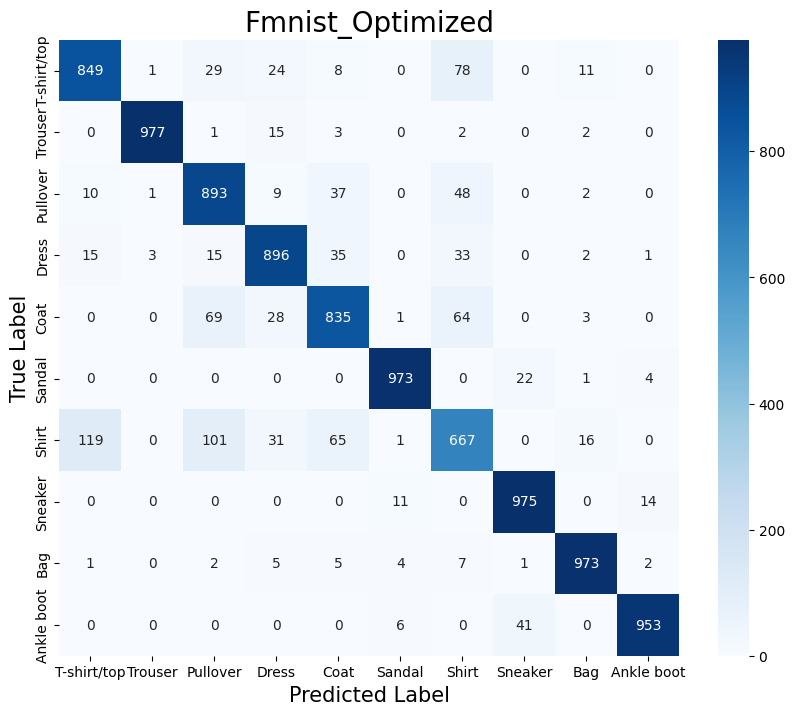

Precision: 0.8987
Recall: 0.8991
Accuracy: 0.8991
F1 Score: 0.8984


In [37]:
model = MyCNN(kernel_size=3,dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
summary(model, (1, 28, 28))

train_loader = torch.utils.data.DataLoader(
                        train_set, batch_size=10, shuffle=True
                    )
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=30,
    name="Fmnist_Optimized",
    MRIData=False,
)

# Optimized MRI Cnn


Configuration 1/1:
LR: 0.0001, BS: 10, Optimizer: Adam, Dropout: 0.3, Kernel: 3
36864
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 225, 225]             320
              ReLU-2         [-1, 32, 225, 225]               0
       BatchNorm2d-3         [-1, 32, 225, 225]              64
         MaxPool2d-4           [-1, 32, 75, 75]               0
            Conv2d-5           [-1, 64, 73, 73]          18,496
              ReLU-6           [-1, 64, 73, 73]               0
       BatchNorm2d-7           [-1, 64, 73, 73]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
           Dropout-9                [-1, 36864]               0
           Linear-10                    [-1, 3]         110,595
          Softmax-11                    [-1, 3]               0
Total params: 129,603
Trainable params: 129,603
Non-trainable params: 0
---------

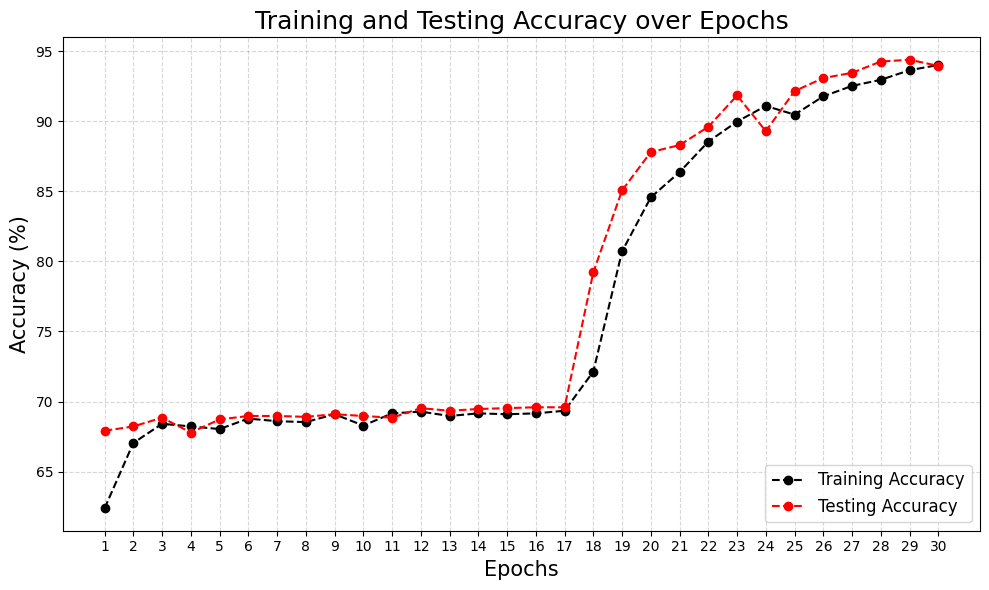

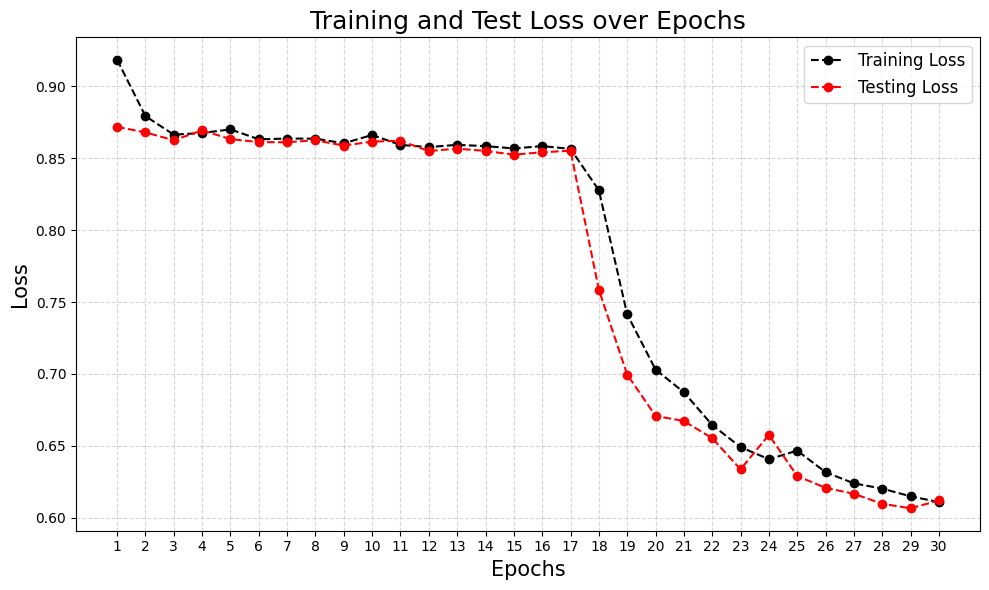

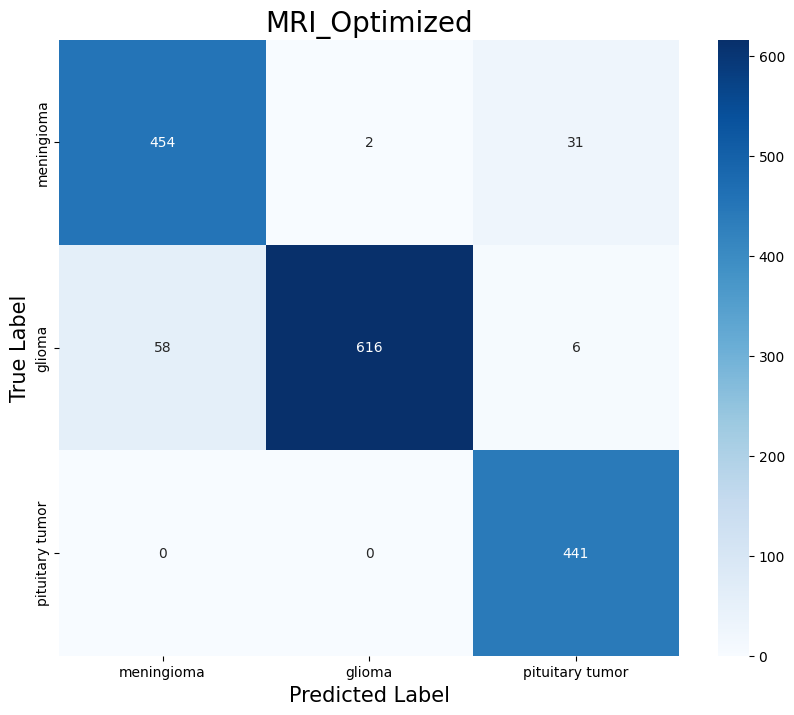

Precision: 0.9354
Recall: 0.9460
Accuracy: 0.9397
F1 Score: 0.9393


In [36]:
learning_rates = [0.0001]
batch_sizes = [10]
optimizers = [torch.optim.Adam]
dropout_rates = [0.3]
kernel_sizes = [3]
num_epochs = 30

config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader_MRI = torch.utils.data.DataLoader(
                        train_set_MRI, batch_size=bs, shuffle=True
                    )
                    test_loader_MRI = torch.utils.data.DataLoader(
                        train_set_MRI, batch_size=bs
                    )
                    model = MyCNN(
                        kernel_size=ks, dropout_rate=dr, classes=3, input_size=227
                    ).to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)
                    summary(model, (1, 227, 227))
                    train_and_evaluate_model(
                        model,
                        train_loader_MRI,
                        test_loader_MRI,
                        criterion,
                        optimizer,
                        num_epochs=30,
                        name="MRI_Optimized",
                    )